## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w -p sklearn

Last updated: Fri Jun 02 2023

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

sklearn: 0.0

matplotlib: 3.3.3
numpy     : 1.19.4
pandas    : 1.1.5
shap      : 0.39.0
seaborn   : 0.11.0

Watermark: 2.1.0



### Miscelaneous configurations

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = 10

output_dir = 'output/RandomForest/'

## Data

Reading the data and translating names from Spanish to English:

In [4]:
stomach = pd.read_csv("data/stomach_w.csv")

# Translate column names
group_names = ['Ind', 'Species', 'Season', 'Sex', 'Maturity']
feature_names = ['Stomatopods', 'Polychaetes', 'Bivalves', 'Amphipods',
                 'Crabs', 'Echinoderms', 'Shrimps', 'Crustaceans', 'Sipunculids', 'Fishes']
stomach.columns = group_names + feature_names

# Translate categories
stomach.Season = stomach.Season.map({'Fria': 'Cold', 'Calida': 'Warm'})
stomach.Sex = stomach.Sex.map({'Hembra': 'Female', 'Macho': 'Male'})
stomach.Maturity = stomach.Maturity.map({'Adulto': 'Adult', 'Juvenil': 'Juvenile'})

# Data preview
stomach.head()

,Ind,Species,Season,Sex,Maturity,Stomatopods,Polychaetes,Bivalves,Amphipods,Crabs,Echinoderms,Shrimps,Crustaceans,Sipunculids,Fishes
0,1,H.dipterurus,Cold,Male,Adult,8.50,3.22,5.23,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,2,H.dipterurus,Cold,Female,Juvenile,0.30,2.02,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,3,H.dipterurus,Warm,Female,Juvenile,0.50,0.40,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,4,H.dipterurus,Warm,Male,Adult,0.01,0.00,2.86,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,5,H.dipterurus,Cold,Female,Juvenile,4.54,2.60,0.11,0.03,0.0,0.0,0.0,0.0,0.0,0.0


Assigning weights as an object (X) and species as other (y):

In [5]:
# Just the grouping columns
stomach_group = stomach.iloc[:, 1:5]

# Weights of the different prey items
X = stomach.iloc[:, 5:]
# Target labels
y = pd.Categorical(stomach_group['Species']).codes

## Model optimization

A Random Forest (RF) classifier was used to model the separation between both species and their categories, given by the weights of each prey group. This approach was preferred over traditional techniques (*e.g.*, PERMANOVA, ANOSIM and/or SIMPER) because it is one of the more efficient machine learning methods and has the following desirable characteristics: a) it is robust to biased distributions, b) it does not require any transformation of the data, c) it is not based on distances or dissimilarities *per se*, and c) it is resistant to overfitting [@Carvajaletal_2018]. The RF approach consists on building *t* independent decision trees and making an ensemble with them; *i.e.*, the probability of pertenence to each class for every observation is based on the frequency of "votes" made by whole "forest". The classification is done via a recursive partitioning of the dataset, combining random subsets of both observations and variables (features) of the original data (*i.e.*, bootstraping and bagging) to "learn" the limits between the target classes for each feature.

Every ML model should be optimized; i.e., its hyper-parameters should be tuned to maximize its performance. Furthermore, that performance should be always evaluated with data unseen by the model to check for overfitting, regardless of the inherent resistance of the approach. In order to achieve both things, the original data set was divided into a train set and a test set. The train set was used to train the model and tune its hyper-parameters using a grid-search and 5-fold cross-validation: i) number of trees in the ensemble; ii) maximum number of features used per tree, and iii) the maximum "depth" of the tree (i.e., the maximum number of partitions applied to the data). The performance metric used for optimization and evaluation was the Area Under the Curve of the Receiver Operator Characteristics (AUC-ROC), which yields a more reliable evaluation than other metrics, such as the accuracy, since the ROC compares the True Positive Rate and the False Positive Rate at various thresholds [@Meyer-BaeseSchmid_2014].

In [6]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [7]:
# Flag to save outputs
classification = 'Global'

# Setting up the optimization via grid-search and cross-validation
rf_clf = RandomForestClassifier(random_state = 0)
grid_values = {'n_estimators': [10, 50, 100, 200, 500],
               'max_features': list(np.arange(1,10)),
               'max_depth': list(np.arange(1,50))}
grid_rf = GridSearchCV(rf_clf,
                       param_grid = grid_values,
                       scoring = 'roc_auc',
                       n_jobs = 8)

In [8]:
%%time
# Optimization of the model
grid_rf.fit(X_train, y_train)

CPU times: user 19.3 s, sys: 2.12 s, total: 21.4 s
Wall time: 6min 25s


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=8,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [9]:
#with open(output_dir + f'models/{classification}', 'wb') as model_file:
#    pickle.dump(grid_rf, model_file)

In [10]:
#with open(output_dir + f'models/{classification}', 'rb') as model_file:
#    grid_rf = pickle.load(model_file)

The final forest consisted of 200 trees, with a maximum depth of 2 and maximum 3 features per tree:

In [11]:
# Probability of belonging to class 1; i.e., N. entemedor
ypred = grid_rf.predict_proba(X_test)[:,1]
# Hyper-parameters of the tuned model
best_params = grid_rf.best_params_
best_params

{'max_depth': 2, 'max_features': 3, 'n_estimators': 200}

The AUC of the test set indicates that the model did not overfit:

In [12]:
print(f'Training AUC: {round(grid_rf.best_score_, 2)}')
print(f'Test AUC: {round(roc_auc_score(y_test, ypred), 2)}' )

Training AUC: 0.98
Test AUC: 0.99


### Model training and prey importances

In [13]:
# Fitting of the optimized model
rf = RandomForestClassifier(max_depth = best_params['max_depth'],
                            max_features = best_params['max_features'],
                            n_estimators = best_params['n_estimators'],
                            n_jobs = 6,
                            random_state = 0).fit(X_train, y_train)

### SHAP explanations

Feature importances for a RF classifier are traditionally based on the Gini index. Simply put, they represent how much would the error rate of the model increase, in terms of the purity of the final nodes of the tree, if each feature was removed from the data. On the other hand, SHAP explanations are a more robust and informative approach. These explanations are based on the Shapely values used in coalitional game theory, that is, they connect optimal prediction allocation with local explations based on Shapely values. Shapely values are a method that involves fairly distributing both gains and costs to the actors working in a coalition and, since each actor contributes differently, the Shapely values make shure that each actor gets a fair share depending on their contribution [@Lunbergetal_2017; @Lundbergetal_2020]. In other words, the SHAP approach assigns a higher contribution to the variables that "worked more" for achieving the correct predictions. The main advantages of this approach are that it is model-agnostic (independent of the model) and that it allows both global and local interpretations.

In [14]:
# Function to create a beeswarm and waterfall plot
# Waterfall plot: barplot showing the relative contributions
# Beeswarm plot: shows the SHAP values for each observation,
# colored by the value of the feature
def make_shap_beefall_plot(shap_values, features, test, fnames):
    
    # Indices of columns
    column_list = features.columns
    # Relative contribution
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    # Ordering of contributions and indices
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    fratio = np.sort(feature_ratio)[::-1]
    
    # Beeswarm plot using SHAP's function
    shap.summary_plot(shap_values, test,
                      feature_names = fnames,
                      show = False,
                      color_bar_label = 'Weight')
    # Get current axes
    ax = plt.gca()
    # Generate a second X axis
    ax2 = ax.twiny()
    # Bar (waterfall) plot
    ax2.barh(column_list[::-1], fratio[::-1], alpha = 0.3, color = 'gray')
    # Set ticks
    ax2.set_xticks(np.linspace(0, round(fratio.max()), 3))
    # Set axis label
    ax2.set_xlabel('Relative contribution (%)');
    # Remove spines
    sns.despine(left = True, bottom = False, top = False, right = True)

In [15]:
# Generate a new "explainer" of the model
explainer = shap.TreeExplainer(rf)
# Get the SHAP values for the test data
shap_values = explainer.shap_values(X_test)

#### Global explanation

The following beeswarm plot not only shows the feature importance, but also displays the positive and negative relationships of the predictors with the target class (*Narcine entemedor*). The more positive the SHAP value, the larger the directly proportional correlation of the feature, meaning that high counts of sipunculids correspond to *N. entemedor*, while low counts are more associated with *H. dipterurus*. Low counts of bivalves, on the other hand, are positively correlated with *N. entemedor* and negatively with *H. dipterurus*. The plot below shows that the main contributior to the differences between both species are mainly due to sipunculids, closely followed by bivalves, explaining ~70% of the differences.

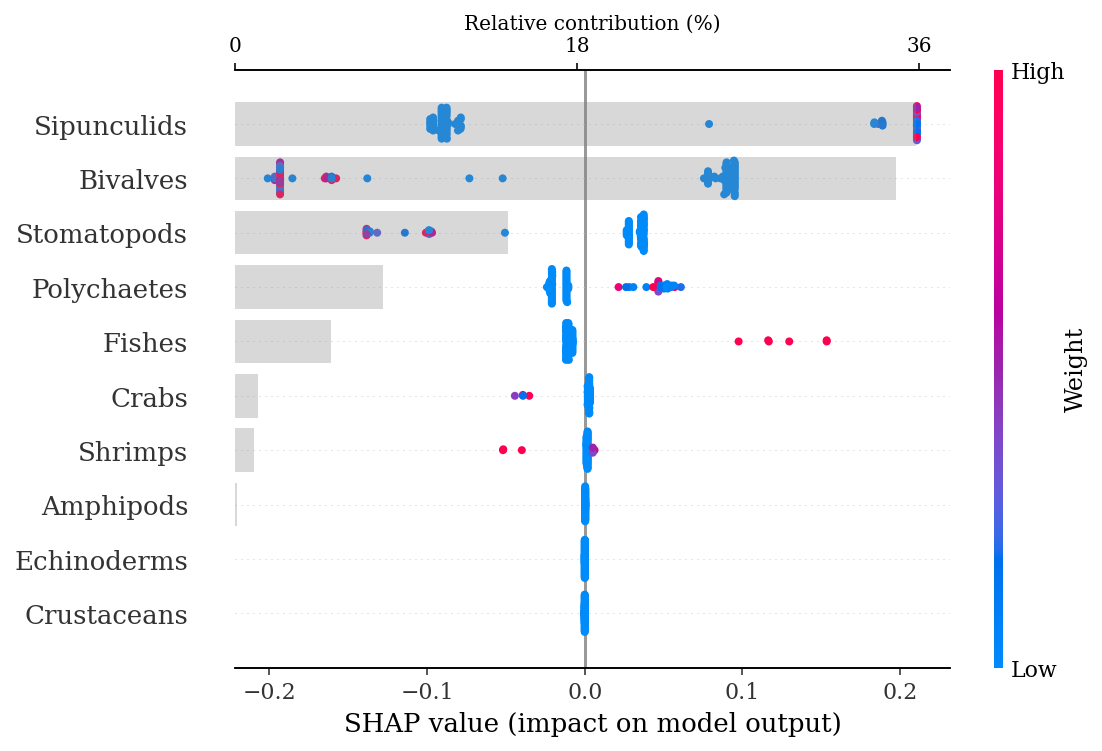

In [16]:
make_shap_beefall_plot(shap_values[1], # values for class 1; i.e., N. entemedor
                       features = X_train, # train set for contributions
                       test = X_test, # test features for beeswarm plot
                       fnames = feature_names)
#plt.gcf().set_size_inches(4*1.61,4)
#plt.savefig(output_dir + f'figures/{classification}/beeswarm_plot.pdf',
#            bbox_inches = 'tight')

An easy way to corroborate those results is showing the total counts of sipunculids and bivalves for each species:

In [17]:
stomach.groupby('Species').agg({'Sipunculids': 'sum',
                                'Bivalves': 'sum'})

,Sipunculids,Bivalves
Species,,
H.dipterurus,200.16,340.873
N.entemedor,1437.10,9.720


#### Local explanations

As for the local interpretations, we can view force plots to explain single observations in the dataset. The 64th individual of the test set had a 1% probability of being *N. entemedor* (`f(x)`; meaning that it was classified as *H. dipterurus*) given by the "high" count of bivalves (more correlated with *H. dipterurus* than *N. entemedor*):

In [18]:
rename = lambda x: 'H. dipterurus' if x == 0 else 'N. entemedor'

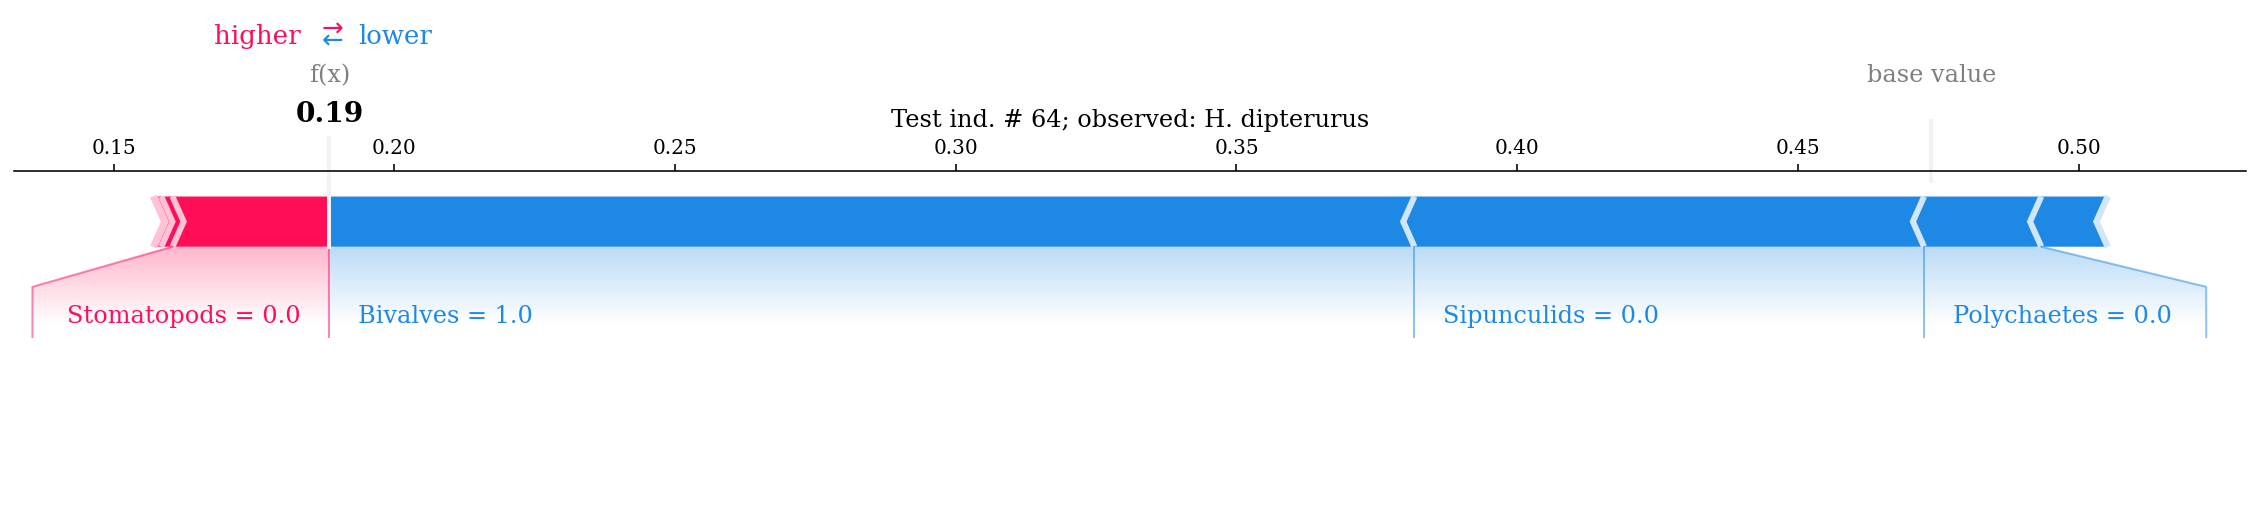

In [19]:
#shap.initjs()
#random_row = np.random.randint(0, 98) # 64
random_row = 64
f = shap.force_plot(explainer.expected_value[1], shap_values[1][random_row],
                    X_test.iloc[random_row],
                    feature_names = feature_names,
                    matplotlib = True,
                    show = False)
plt.title(f'Test ind. # {random_row}; observed: {rename(y_test[random_row])}');

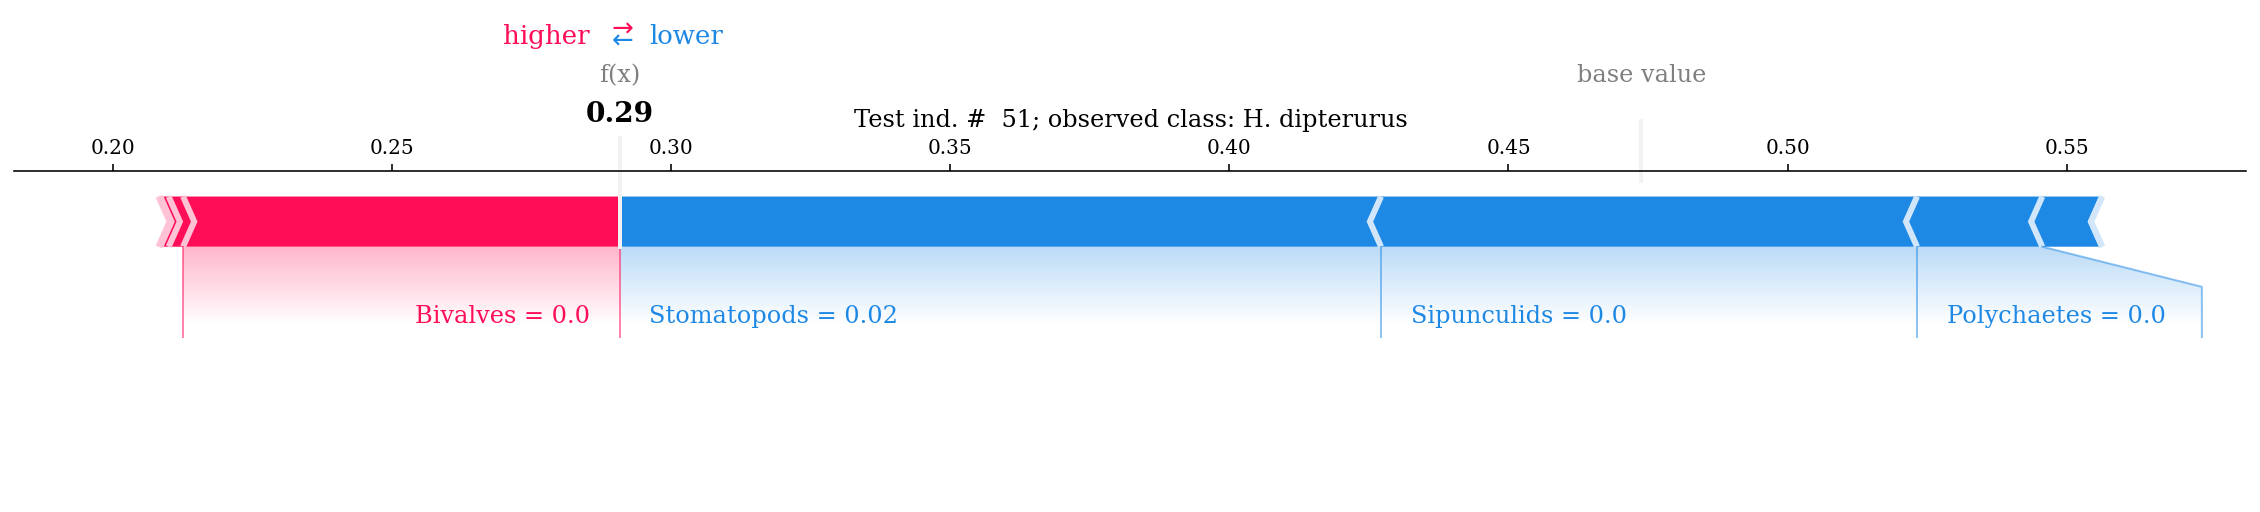

In [20]:
#shap.initjs()
#random_row = np.random.randint(0, 98) # 51
random_row = 51
f = shap.force_plot(explainer.expected_value[1], shap_values[1][random_row],
                    X_test.iloc[random_row],
                    feature_names = feature_names,
                    matplotlib = True,
                    show = False)
plt.title(f'Test ind. #  {random_row}; observed class: {rename(y_test[random_row])}');

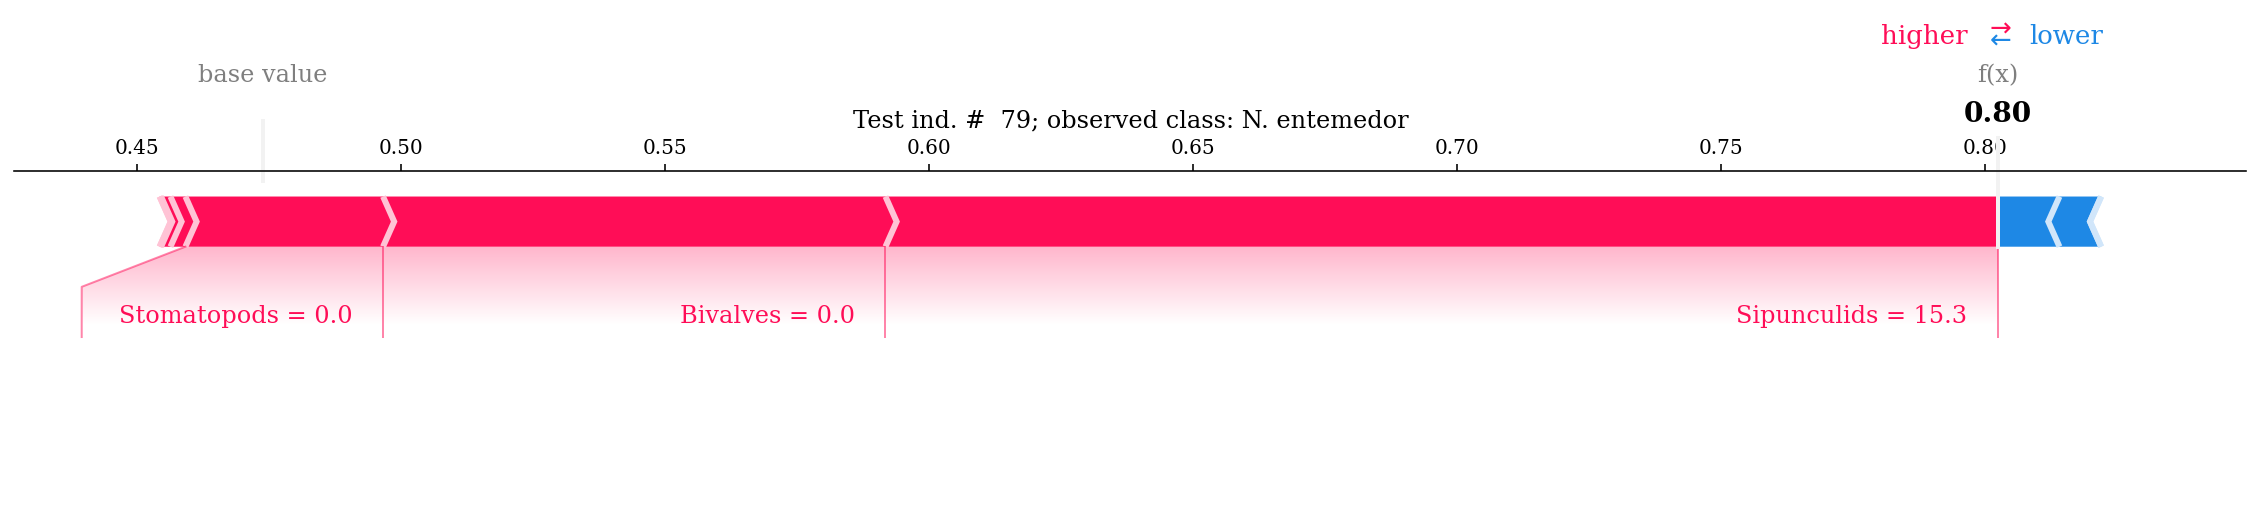

In [21]:
#shap.initjs()
#random_row = np.random.randint(0, 98) # 79
random_row = 79
f = shap.force_plot(explainer.expected_value[1], shap_values[1][random_row],
                    X_test.iloc[random_row],
                    feature_names = feature_names,
                    matplotlib = True,
                    show = False)
plt.title(f'Test ind. #  {random_row}; observed class: {rename(y_test[random_row])}');

## Intra-specific differences

Unlike the previous RF in which we tried to discriminate two species, here we will try to discriminate both levels of each covariate within each species.

### *H. dipterurus*

In [22]:
stomach_hd = stomach[stomach['Species'] == 'H.dipterurus'].iloc[:, 2:]
species = 'Hd'

The first step is to check for class imbalances. Only the seasons were balanced (~50% of observations for each class); hence, the other two were pre-processed via undersampling of the majority class and oversampling of the minority class using the Synthetic Majority Oversampling TEchnique. In short, this technique selects examples that are close in the feature space and draws a new sample at a point along that line, allowing to generate as many synthetic observations as required; however, the random undersampling of the majority class is also recommended [@Chawlaetal_2002].

In [23]:
season_n = stomach_hd.groupby('Season').agg({'Season':'count'}).rename(columns = {'Season':'n'})
season_n

,n
Season,
Cold,109
Warm,96


In [24]:
sex_n = stomach_hd.groupby('Sex').agg({'Sex':'count'}).rename(columns = {'Sex':'n'})
sex_n

,n
Sex,
Female,138
Male,67


In [25]:
age_n = stomach_hd.groupby('Maturity').agg({'Maturity':'count'}).rename(columns = {'Maturity': 'n'})
age_n

,n
Maturity,
Adult,44
Juvenile,161


#### Sexes

In [26]:
classification = 'Sex'
sex_n

,n
Sex,
Female,138
Male,67


The sexes were balanced to 100 individuals per class. First, a random undersampling:

In [27]:
# Random undersampling
under_female = stomach_hd[stomach_hd.Sex == 'Female'].sample(n = 100, random_state = 0)
under_sex = under_female.append(stomach_hd[stomach_hd.Sex == 'Male'])
under_sex.Sex = pd.Categorical(under_sex.Sex).codes

Then we apply SMOTE to finish balancing the dataset:

In [28]:
sex_balanced = SMOTE(random_state = 0).fit_resample(under_sex.iloc[:, 3:], under_sex.Sex)

Next we generate the train-test split of the balanced dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(sex_balanced[0], sex_balanced[1], random_state = 0)

And optimize the Random Forest Classifier

In [30]:
rfm = RandomForestClassifier(random_state = 0)
grid_rfm = GridSearchCV(rfm,
                        param_grid = grid_values,
                        scoring = 'roc_auc',
                        n_jobs = 8)

In [31]:
%%time
grid_rfm.fit(X_train, y_train)

CPU times: user 12.9 s, sys: 1.03 s, total: 13.9 s
Wall time: 6min 10s


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=8,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [32]:
#with open(output_dir + f'models/{classification}', 'wb') as model_file:
#    pickle.dump(grid_rfm, model_file)

In [33]:
#with open(output_dir + f'models/{classification}', 'rb') as model_file:
#    grid_rfm = pickle.load(model_file)

The forest was optimized with 50 trees, with a maximum depth of 28 and maximum one feature per tree:

In [34]:
best_params = grid_rfm.best_params_
best_params, grid_rfm.best_score_

({'max_depth': 28, 'max_features': 1, 'n_estimators': 50}, 0.7091428571428571)

In [35]:
rf = RandomForestClassifier(max_depth = best_params['max_depth'],
                            max_features = best_params['max_features'],
                            n_estimators = best_params['n_estimators'],
                            n_jobs = 6,
                            random_state = 0).fit(X_train, y_train)

In [36]:
ypred = rf.predict_proba(X_test)[:,1]

The AUC of the test set indicates that the model did overfit and performed just better than random guessing (AUC = 0.5):

In [37]:
print(f'Training AUC: {round(grid_rfm.best_score_, 2)}')
print(f'Test AUC: {round(roc_auc_score(y_test, ypred), 2)}' )

Training AUC: 0.71
Test AUC: 0.6


##### SHAP explanations

In [38]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

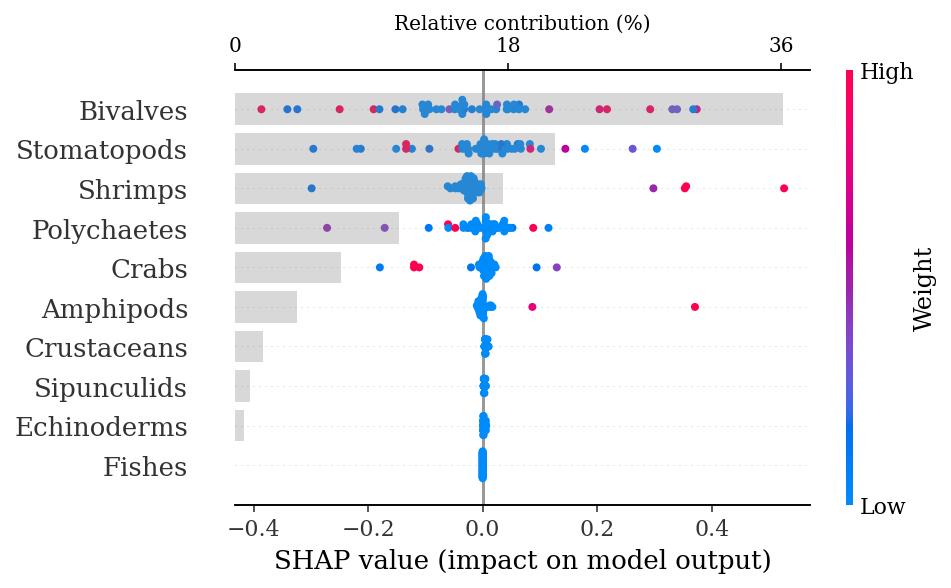

In [39]:
make_shap_beefall_plot(shap_values[1],
                       features = X_train,
                       test = X_test,
                       fnames = feature_names)
plt.gcf().set_size_inches(4*1.61,4)
plt.savefig(output_dir + f'figures/Hd/{classification}/beeswarm_plot.pdf',
            bbox_inches = 'tight')

#### Maturity stages

In [40]:
classification = 'Maturity'
age_n

,n
Maturity,
Adult,44
Juvenile,161


The maturity stages were also balanced to 100 individuals per class

In [41]:
# Random undersampling
under_juv = stomach_hd[stomach_hd.Maturity == 'Juvenile'].sample(n = 100, random_state = 0)
under_age = under_juv.append(stomach_hd[stomach_hd.Maturity == 'Adult'])
under_age.Maturity = pd.Categorical(under_age.Maturity).codes

In [42]:
# SMOTE balancing
age_balanced = SMOTE(random_state = 0).fit_resample(under_age.iloc[:, 3:],
                                                    under_age.Maturity)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(age_balanced[0],
                                                    age_balanced[1],
                                                    random_state = 0)

In [44]:
rfm = RandomForestClassifier(random_state = 0)
grid_rfm = GridSearchCV(rfm,
                        param_grid = grid_values,
                        scoring = 'roc_auc',
                        n_jobs = 6)

In [45]:
%%time
grid_rfm.fit(X_train, y_train)

CPU times: user 9.11 s, sys: 669 ms, total: 9.77 s
Wall time: 6min 55s


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=6,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [46]:
#with open(output_dir + f'models/{classification}', 'wb') as model_file:
#    pickle.dump(grid_rfm, model_file)

In [47]:
#with open(output_dir + f'models/{classification}', 'rb') as model_file:
#    grid_rfm = pickle.load(model_file)

In [48]:
best_params = grid_rfm.best_params_
best_params, grid_rfm.best_score_

({'max_depth': 5, 'max_features': 4, 'n_estimators': 50}, 0.6613650793650794)

In [49]:
rf = RandomForestClassifier(max_depth = best_params['max_depth'],
                            max_features = best_params['max_features'],
                            n_estimators = best_params['n_estimators'],
                            n_jobs = 6,
                            random_state = 0).fit(X_train, y_train)

In [50]:
ypred = rf.predict_proba(X_test)[:,1]

The AUC of the test set indicates that the model did not overfit:

In [51]:
print(f'Training AUC: {round(grid_rfm.best_score_, 2)}')
print(f'Test AUC: {round(roc_auc_score(y_test, ypred), 2)}' )

Training AUC: 0.66
Test AUC: 0.6


##### SHAP explanations

In [52]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

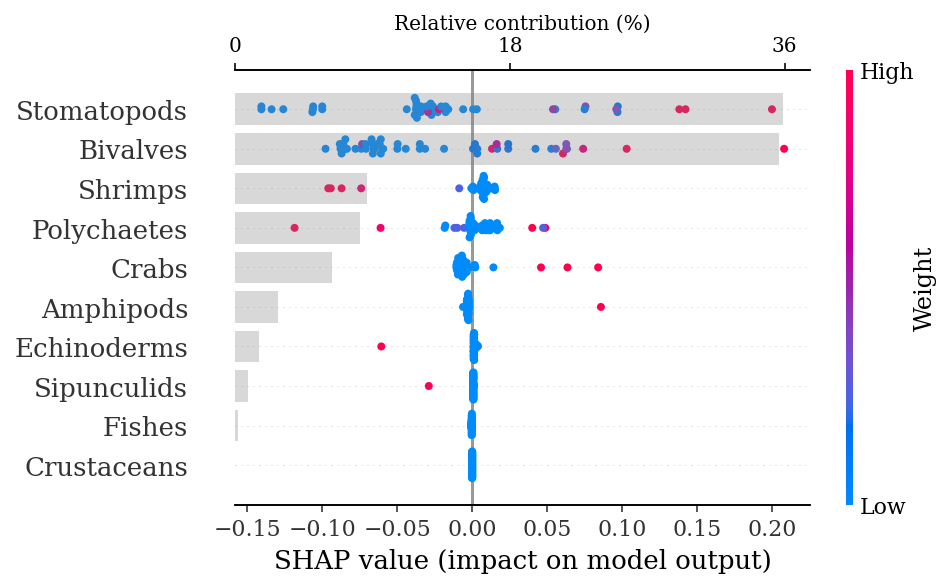

In [53]:
make_shap_beefall_plot(shap_values[1],
                       features = X_train,
                       test = X_test,
                       fnames = feature_names)
plt.gcf().set_size_inches(4*1.61,4)
plt.savefig(output_dir + f'figures/Hd/{classification}/beeswarm_plot.pdf',
            bbox_inches = 'tight')

#### Season

In [54]:
classification = 'Season'
season_n

,n
Season,
Cold,109
Warm,96


In [55]:
X_train, X_test, y_train, y_test = train_test_split(stomach_hd.iloc[:,3:],
                                                    stomach_hd.Season, random_state = 0)

In [56]:
rfm = RandomForestClassifier(random_state = 0)
grid_rfm = GridSearchCV(rfm,
                        param_grid = grid_values,
                        scoring = 'roc_auc',
                        n_jobs = 6)

In [57]:
%%time
grid_rfm.fit(X_train, y_train)

CPU times: user 9.15 s, sys: 673 ms, total: 9.82 s
Wall time: 6min 57s


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=6,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [58]:
#with open(output_dir + f'models/{classification}', 'wb') as model_file:
#    pickle.dump(grid_rfm, model_file)

In [59]:
#with open(output_dir + f'models/{classification}', 'rb') as model_file:
#    grid_rfm = pickle.load(model_file)

In [60]:
best_params = grid_rfm.best_params_
best_params, grid_rfm.best_score_

({'max_depth': 2, 'max_features': 1, 'n_estimators': 100}, 0.6250892857142857)

In [61]:
rf = RandomForestClassifier(max_depth = best_params['max_depth'],
                            max_features = best_params['max_features'],
                            n_estimators = best_params['n_estimators'],
                            n_jobs = 6,
                            random_state = 0).fit(X_train, y_train)

In [62]:
ypred = rf.predict_proba(X_test)[:,1]

In [63]:
print(f'Training AUC: {round(grid_rfm.best_score_, 2)}')
print(f'Test AUC: {round(roc_auc_score(y_test, ypred), 2)}' )

Training AUC: 0.63
Test AUC: 0.55


##### SHAP explanations

In [64]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

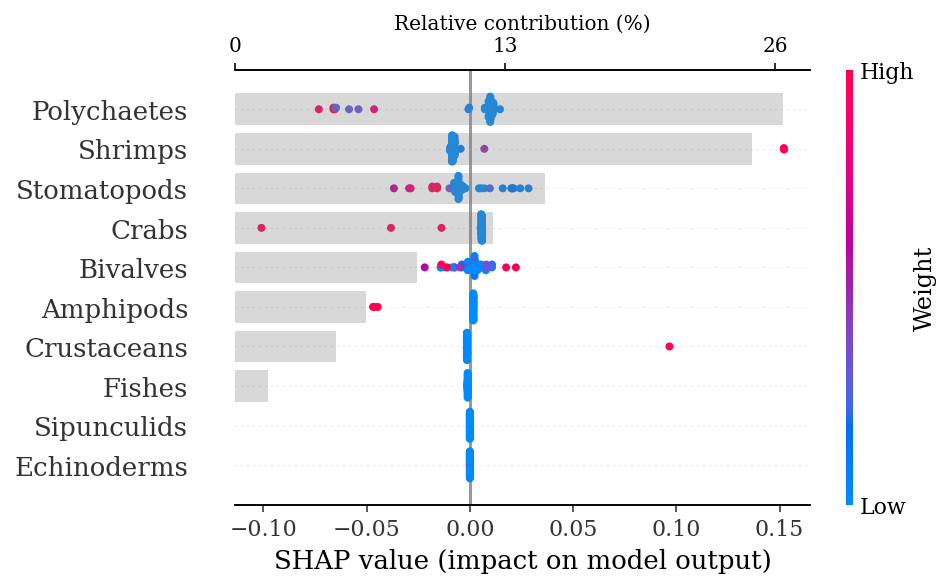

In [65]:
make_shap_beefall_plot(shap_values[1],
                       features = X_train,
                       test = X_test,
                       fnames = feature_names)
plt.gcf().set_size_inches(4*1.61,4)
plt.savefig(output_dir + f'figures/Hd/{classification}/beeswarm_plot.pdf',
            bbox_inches = 'tight')

### *N. entemedor*

In [66]:
species = 'Ne'
stomach_ne = stomach[stomach['Species'] == 'N.entemedor'].iloc[:, 2:]

The first step is to check for class imbalances. The season variable was the only one balanced (~50% of observations for each class), hence, the other two were pre-processed via undersampling of the overrepresented class and oversampling of the underrepresented class.

#### Sex

In [67]:
classification = 'Sex'
sex_n = stomach_ne.groupby('Sex').agg({'Sex':'count'}).rename(columns = {'Sex':'n'})
sex_n

,n
Sex,
Female,154
Male,33


The sexes were balanced to 100 observations per class

In [68]:
# Random undersampling
under_female = stomach_ne[stomach_ne.Sex == 'Female'].sample(n = 100, random_state = 0)
under_sex = under_female.append(stomach_ne[stomach_ne.Sex == 'Male'])
under_sex.Sex = pd.Categorical(under_sex.Sex).codes

In [69]:
# SMOTE balancing
sex_balanced = SMOTE(random_state = 0).fit_resample(under_sex.iloc[:, 3:], under_sex.Sex)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(sex_balanced[0], sex_balanced[1], random_state = 0)

In [71]:
rfm = RandomForestClassifier(random_state = 0)
grid_rfm = GridSearchCV(rfm,
                        param_grid = grid_values,
                        scoring = 'roc_auc',
                        n_jobs = 6)

In [72]:
%%time
grid_rfm.fit(X_train, y_train)

CPU times: user 8.83 s, sys: 629 ms, total: 9.46 s
Wall time: 6min 41s


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=6,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [73]:
#with open(output_dir + f'models/{classification}', 'wb') as model_file:
#    pickle.dump(grid_rfm, model_file)

In [74]:
#with open(output_dir + f'models/{classification}', 'rb') as model_file:
#    grid_rfm = pickle.load(model_file)

In [75]:
best_params = grid_rfm.best_params_
best_params, grid_rfm.best_score_

({'max_depth': 7, 'max_features': 7, 'n_estimators': 100}, 0.8695496031746032)

In [76]:
rf = RandomForestClassifier(max_depth = best_params['max_depth'],
                            max_features = best_params['max_features'],
                            n_estimators = best_params['n_estimators'],
                            n_jobs = 6,
                            random_state = 0).fit(X_train, y_train)

In [77]:
ypred = rf.predict_proba(X_test)[:,1]

The AUC of the test set indicates that the model did not overfit:

In [78]:
print(f'Training AUC: {round(grid_rfm.best_score_, 2)}')
print(f'Test AUC: {round(roc_auc_score(y_test, ypred), 2)}')

Training AUC: 0.87
Test AUC: 0.87


##### SHAP explanations

In [79]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

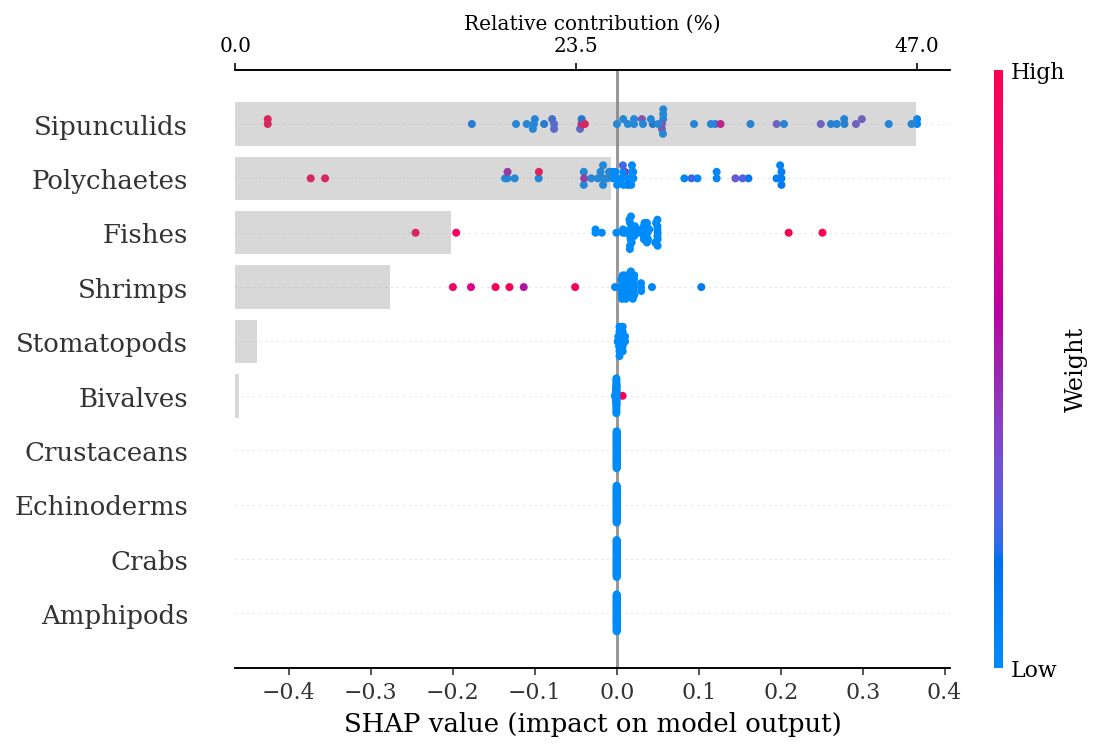

In [80]:
make_shap_beefall_plot(shap_values[1],
                       features = X_train,
                       test = X_test,
                       fnames = feature_names)
#plt.gcf().set_size_inches(4*1.61,4)
#plt.savefig(output_dir + f'figures/Ne/{classification}/beeswarm_plot.pdf',
#            bbox_inches = 'tight')

#### Maturity stages

In [81]:
classification = 'Maturity'
age_n = stomach_ne.groupby('Maturity').agg({'Maturity':'count'}).rename(columns = {'Maturity': 'n'})
age_n

,n
Maturity,
Adult,173
Juvenile,14


The balancing was done to 50 observations per class

In [82]:
# Random undersampling
under_juv = stomach_ne[stomach_ne.Maturity == 'Adult'].sample(n = 50, random_state = 0)
under_age = under_juv.append(stomach_ne[stomach_ne.Maturity == 'Juvenile'])
under_age.Maturity = pd.Categorical(under_age.Maturity).codes

In [83]:
# SMOTE balancing
age_balanced = SMOTE(random_state = 0).fit_resample(under_age.iloc[:, 3:], under_age.Maturity)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(age_balanced[0], age_balanced[1], random_state = 0)

In [85]:
rfm = RandomForestClassifier(random_state = 0)
grid_rfm = GridSearchCV(rfm,
                        param_grid = grid_values,
                        scoring = 'roc_auc',
                        n_jobs = 6)

In [86]:
%%time
grid_rfm.fit(X_train, y_train)

CPU times: user 8.96 s, sys: 640 ms, total: 9.6 s
Wall time: 6min 37s


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=6,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [87]:
#with open(output_dir + f'models/{classification}', 'wb') as model_file:
#    pickle.dump(grid_rfm, model_file)

In [88]:
#with open(output_dir + f'models/{classification}', 'rb') as model_file:
#    grid_rfm = pickle.load(model_file)

In [89]:
best_params = grid_rfm.best_params_
best_params, grid_rfm.best_score_

({'max_depth': 4, 'max_features': 8, 'n_estimators': 100}, 0.7642857142857143)

In [90]:
rf = RandomForestClassifier(max_depth = best_params['max_depth'],
                            max_features = best_params['max_features'],
                            n_estimators = best_params['n_estimators'],
                            n_jobs = 6,
                            random_state = 0).fit(X_train, y_train)

In [91]:
ypred = rf.predict_proba(X_test)[:,1]

The AUC of the test set indicates that the model did not overfit:

In [92]:
print(f'Training AUC: {round(grid_rfm.best_score_, 2)}')
print(f'Test AUC: {round(roc_auc_score(y_test, ypred), 2)}' )

Training AUC: 0.76
Test AUC: 0.83


##### SHAP explanations

In [93]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

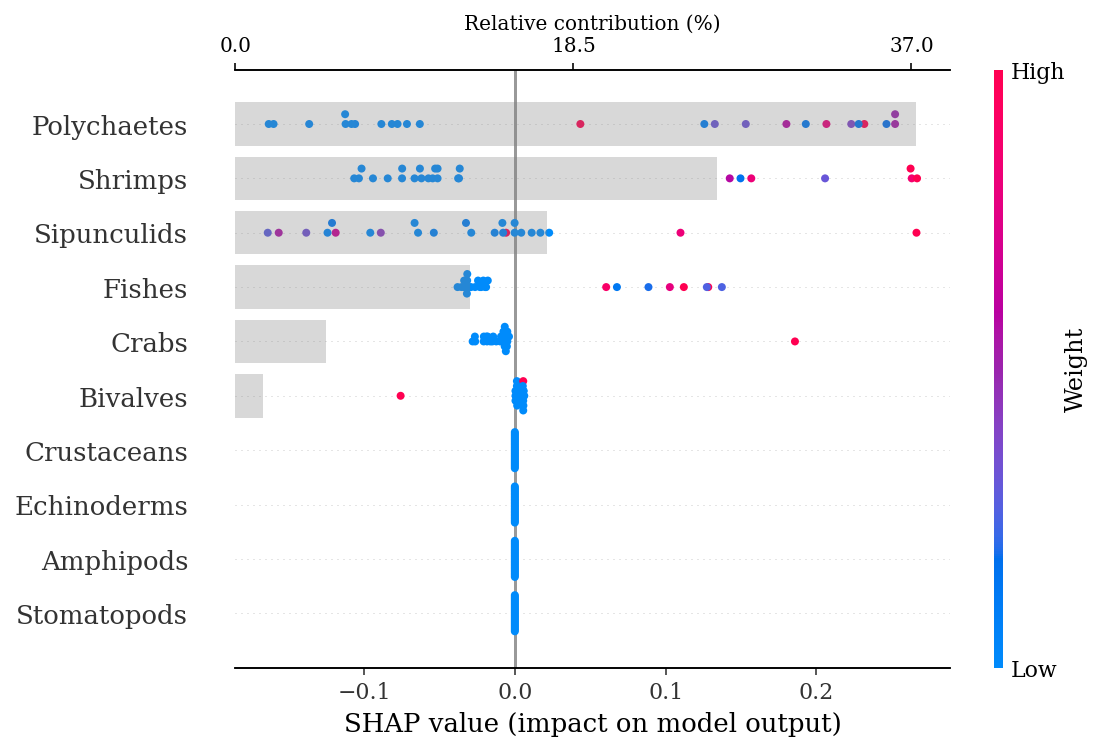

In [94]:
make_shap_beefall_plot(shap_values[1],
                       features = X_train,
                       test = X_test,
                       fnames = feature_names)
#plt.gcf().set_size_inches(4*1.61,4)
#plt.savefig(output_dir + f'figures/Ne/{classification}/beeswarm_plot.pdf',
#            bbox_inches = 'tight')

#### Season

In [95]:
classification = 'Season'
season_n = stomach_ne.groupby('Season').agg({'Season':'count'}).rename(columns = {'Season':'n'})
season_n

,n
Season,
Cold,99
Warm,88


In [96]:
X_train, X_test, y_train, y_test = train_test_split(stomach_ne.iloc[:,3:],
                                                    stomach_ne.Season, random_state = 0)

In [97]:
rfm = RandomForestClassifier(random_state = 0)
grid_rfm = GridSearchCV(rfm,
                        param_grid = grid_values,
                        scoring = 'roc_auc',
                        n_jobs = 6)

In [98]:
%%time
grid_rfm.fit(X_train, y_train)

CPU times: user 8.85 s, sys: 629 ms, total: 9.48 s
Wall time: 6min 44s


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=6,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [99]:
#with open(output_dir + f'models/{classification}', 'wb') as model_file:
#    pickle.dump(grid_rfm, model_file)

In [100]:
#with open(output_dir + f'models/{classification}', 'rb') as model_file:
#    grid_rfm = pickle.load(model_file)

In [101]:
best_params = grid_rfm.best_params_
best_params, grid_rfm.best_score_

({'max_depth': 1, 'max_features': 9, 'n_estimators': 50}, 0.6866586538461539)

In [102]:
rf = RandomForestClassifier(max_depth = best_params['max_depth'],
                            max_features = best_params['max_features'],
                            n_estimators = best_params['n_estimators'],
                            n_jobs = 6,
                            random_state = 0).fit(X_train, y_train)

In [103]:
ypred = rf.predict_proba(X_test)[:,1]

In [104]:
print(f'Training AUC: {round(grid_rfm.best_score_, 2)}')
print(f'Test AUC: {round(roc_auc_score(y_test, ypred), 2)}' )

Training AUC: 0.69
Test AUC: 0.6


##### SHAP explanations

In [105]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

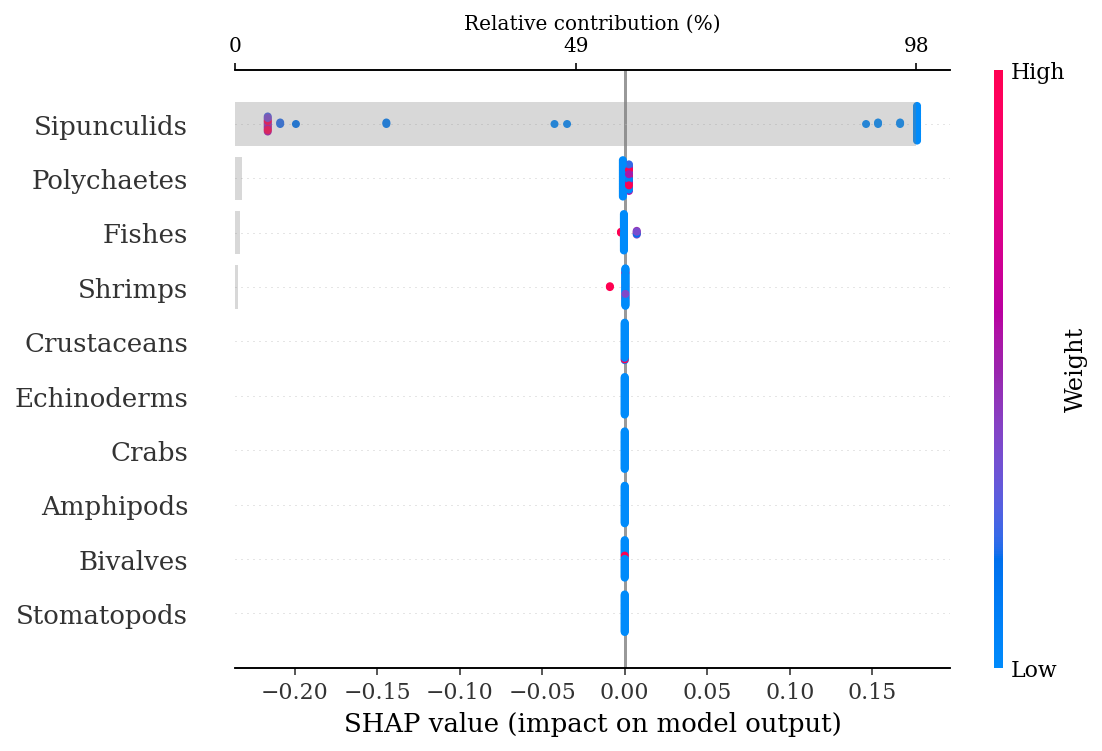

In [106]:
make_shap_beefall_plot(shap_values[1],
                       features = X_train,
                       test = X_test,
                       fnames = feature_names)
#plt.gcf().set_size_inches(4*1.61,4)
#plt.savefig(output_dir + f'figures/Ne/{classification}/beeswarm_plot.pdf',
#            bbox_inches = 'tight')